In [ ]:
import os

# Data manipulation and analysis.
import pandas as pd

# Has multi-dimensional arrays and matrices.
import numpy as np

# Data visualization tools.
import seaborn as sns

import random
import secrets

import matplotlib.pyplot as plt

# Used for efficiency checks
import timeit

# Data visualization
import networkx as nx

# Using mesa module for making the ABM
import mesa

# Data visualization interactive
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.sparse import csr_matrix

# Required dep for visualization
import nbformat

# Multithreading go brr
import threading

In [2]:
# Constants
INFLUENCE_RATE = 0.05 # η - Controls the speed of opinion change
EXTERNAL_INFLUENCE_STRENGTH = 0.3 # α - Strength of external propaganda
OPINION_DIFF_SENSITIVITY = 0.6 # β - Sensitivity to opinion differences for link formation
BREAK_THRESHOLD = 0.3 # Δ_break - Threshold for breaking links
PROPAGANDA_INITIAL_SENSITIVITY = 0.9 # Sensitivity to propaganda agents used for creating initial links
PROPAGANDA_SENSITIVITY = 1.0 # Sensitivity to propaganda agents used for breaking links with hubs
REVOLT_THRESHOLD = 0.8 # Threshold for revolt
NEIGHBOR_DIVERGENCE_THRESHOLD = 0.7 # Threshold for breaking links with neighbors after revolt
NEIGHBOR_SIMILARITY_THRESHOLD = 0.3 # Threshold for forming links with new individuals after revolt
CURRENT_STEP = 0 # Will be used as global for tracking current step

In [3]:
# Create empty NetworkX graph
graph = nx.Graph()

In [4]:
# Class for individual, based on agent.
# Contains the required information that forms the basis of interactions
# The interactions are their own classes that happen at each time-step

class IndividualAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.unique_id = unique_id
        self.name = f"Individual {unique_id}"
        self.opinion = np.random.uniform(-1, 1)
        self.resistance = np.random.uniform(0, 1)
        self.influence = np.random.uniform(0.8, 1.5)
        self.revolt_threshold = np.random.uniform(0.7, 1)

    def say_hi(self):
        print(f"Hi, I am {self.name} with opinion {self.opinion}, resistance {self.resistance}, influence {self.influence}, and revolt threshold {self.revolt_threshold}")

In [5]:
# Class for individual, based on agent.
# Contains the required information that forms the basis of interactions
# The interactions are their own classes that happen at each time-step

class PropagandaHub(mesa.Agent):
    def __init__(self, unique_id, model, opinion, influence_radius, influence_strength):
        super().__init__(model)
        self.unique_id = unique_id
        self.name = f"Propaganda Hub {unique_id}"
        self.opinion = opinion
        self.influence_radius = influence_radius
        self.influence_strength = influence_strength

    def say_hi(self):
        print(f"Hi, I am an propaganda agent, you can call me {self.name} and I have the id of {str(self.unique_id)}. \
      I have the opinion of {self.opinion}, and influence strength is {self.influence_strength}\
      with a radius of {self.influence_radius}.")

    

In [6]:
class ExperimentModel(mesa.Model):
    def __init__(self, n_individuals, n_propaganda_hubs):
        super().__init__()
        self.num_individuals = n_individuals
        self.num_propaganda_hubs = n_propaganda_hubs
        self.schedule = mesa.time.RandomActivation(self)
        self.graph = nx.Graph()
        self.metrics = {
            "opinion_distribution": [],
            "polarization_index": [],
            "cascade_thresholds": [],
            "average_degree": [],
            "revolt_frequency": []
        }

        # Create agents
        self.individuals = [IndividualAgent(i, self) for i in range(n_individuals)]
        self.hubs = [
            PropagandaHub(i + n_individuals, self, np.random.choice([-1, 1]),
                          np.random.uniform(10, 100), np.random.uniform(0.4, 1))
            for i in range(n_propaganda_hubs)
        ]

        # Add agents to scheduler and graph
        for agent in self.individuals + self.hubs:
            self.schedule.add(agent)
            self.graph.add_node(agent.unique_id)

        # Create edges
        self.create_edges()

        # Data structures for optimization
        self.individual_opinions = np.array([agent.opinion for agent in self.individuals])
        self.resistances = np.array([agent.resistance for agent in self.individuals])
        self.influences = np.array([agent.influence for agent in self.individuals])
        self.hub_opinions = np.array([hub.opinion for hub in self.hubs])
        self.hub_strengths = np.array([hub.influence_strength for hub in self.hubs])
        self.hub_radii = np.array([hub.influence_radius for hub in self.hubs])
        self.adjacency_matrix = nx.to_scipy_sparse_array(self.graph, format="csr")

    def create_edges(self):
        # Connect individuals probabilistically
        individual_ids = [agent.unique_id for agent in self.individuals]
        opinions = np.array([agent.opinion for agent in self.individuals])
        differences = np.abs(opinions[:, None] - opinions)
        connection_probs = (np.random.rand(len(opinions), len(opinions)) < 0.1) & (differences < OPINION_DIFF_SENSITIVITY)
        np.fill_diagonal(connection_probs, 0)
        edges = np.argwhere(connection_probs)
        self.graph.add_edges_from([(individual_ids[i], individual_ids[j]) for i, j in edges])

        # Connect hubs to individuals based on opinion similarity
        hub_ids = [hub.unique_id for hub in self.hubs]
        hub_opinions = np.array([hub.opinion for hub in self.hubs])
        hub_individual_differences = np.abs(hub_opinions[:, None] - opinions)
        hub_connection_probs = (hub_individual_differences < PROPAGANDA_INITIAL_SENSITIVITY)
        for i, hub_id in enumerate(hub_ids):
            connections = np.argwhere(hub_connection_probs[i]).flatten()
            self.graph.add_edges_from([(hub_id, individual_ids[j]) for j in connections])

        # Update adjacency matrix
        self.adjacency_matrix = nx.to_scipy_sparse_array(self.graph, format="csr")


    def track_metrics(self):
        """Track metrics at each step."""
        # Opinion distribution (track opinions only for individuals)
        opinions = self.individual_opinions.copy()
        self.metrics["opinion_distribution"].append(opinions)

        # Polarization index
        polarization_index = np.mean(np.abs(opinions))
        self.metrics["polarization_index"].append(polarization_index)

        # Cascade thresholds
        if len(self.metrics["opinion_distribution"]) > 1:
            prev_opinions = self.metrics["opinion_distribution"][-2]
            cascades = np.sum(np.abs(opinions - prev_opinions) > 0.1)  # Example threshold
            self.metrics["cascade_thresholds"].append(cascades)
        else:
            self.metrics["cascade_thresholds"].append(0)

        # Network dynamics (average degree)
        degrees = [degree for _, degree in self.graph.degree()]
        avg_degree = np.mean(degrees)
        self.metrics["average_degree"].append(avg_degree)

        # Revolt frequency
        revolt_count = np.sum(opinions > REVOLT_THRESHOLD)  # Count revolts (as an example)
        self.metrics["revolt_frequency"].append(revolt_count)

    def step(self):
        """Advance the model by one step."""

        global CURRENT_STEP
        CURRENT_STEP += 1
        print(f"Current step is {CURRENT_STEP}!")


        adjacency = self.adjacency_matrix
    
        # Pad opinions and influences to include zeros for hubs
        padded_opinions = np.concatenate([self.individual_opinions, np.zeros(self.num_propaganda_hubs)])
        padded_influences = np.concatenate([self.influences, np.zeros(self.num_propaganda_hubs)])
    
        # --- Influence Calculations ---
        neighbor_influences = adjacency.dot(padded_opinions * padded_influences)
        neighbor_weights = adjacency.dot(padded_influences)
        neighbor_effect = np.divide(neighbor_influences, neighbor_weights, where=neighbor_weights != 0) - padded_opinions
    
        # Propaganda influence
        # Pad hub_opinions with zeros to match the number of individuals
        padded_hub_opinions = np.concatenate([np.zeros(self.num_individuals), self.hub_opinions])
    
        # Calculate propaganda effect using the padded array
        propaganda_effect = adjacency.dot(padded_hub_opinions * EXTERNAL_INFLUENCE_STRENGTH)
    
        # Total opinion updates (only for individuals)
        total_effect = INFLUENCE_RATE * (neighbor_effect[:self.num_individuals] + propaganda_effect[:self.num_individuals])
        self.individual_opinions = np.clip(self.individual_opinions + total_effect, -1, 1)
    
        # --- Network Updates ---
        opinion_diffs = np.abs(self.individual_opinions[:, None] - self.individual_opinions)
        break_links = (opinion_diffs > BREAK_THRESHOLD).astype(int)
        
        # Pad break_links with zeros to match the adjacency matrix dimensions
        padded_break_links = np.zeros(self.adjacency_matrix.shape)
        break_links_sparse = csr_matrix(padded_break_links)
        padded_break_links[:self.num_individuals, :self.num_individuals] = break_links

    
        # Update adjacency matrix using the padded break_links
        self.adjacency_matrix = adjacency - break_links_sparse
    
        # --- Revolt Mechanics ---
        divergences = np.abs(
            adjacency.dot(padded_opinions)[:self.num_individuals] /
            adjacency.sum(axis=1).flatten()[:self.num_individuals] - 
            self.individual_opinions
        )
        revolts = divergences > REVOLT_THRESHOLD
        for i, revolted in enumerate(revolts):
            if revolted:
                # Break all connections for the revolted agent
                self.adjacency_matrix[i] = 0
    
                # Shift opinion to an extreme based on dominant influence
                dominant_influence = 1 if np.sum(self.adjacency_matrix[i]) > 0 else -1
                self.individual_opinions[i] = dominant_influence
    
                # Create new ties with agents holding similar opinions
                similar_agents = np.where(np.abs(self.individual_opinions - self.individual_opinions[i]) < NEIGHBOR_SIMILARITY_THRESHOLD)[0]
                for j in similar_agents:
                    self.adjacency_matrix[i, j] = 1
                    self.adjacency_matrix[j, i] = 1
    
        # Update the graph
        self.graph = nx.from_scipy_sparse_array(self.adjacency_matrix, create_using=nx.Graph)

        self.track_metrics()


        # Add metadata for nodes
        for agent in self.schedule.agents:
            if agent.unique_id in self.graph:
                # Add metadata depending on the agent type
                if isinstance(agent, IndividualAgent):
                    self.graph.nodes[agent.unique_id].update({
                        "type": "Individual",
                        "opinion": agent.opinion,
                        "resistance": agent.resistance,
                        "influence": agent.influence,
                        "revolt_threshold": agent.revolt_threshold,
                    })
                elif isinstance(agent, PropagandaHub):
                    self.graph.nodes[agent.unique_id].update({
                        "type": "PropagandaHub",
                        "opinion": agent.opinion,
                        "influence_radius": agent.influence_radius,
                        "influence_strength": agent.influence_strength,
                    })

        # Save the graph in GraphML format
        output_dir = "graphml_exports"
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        filename = os.path.join(output_dir, f"graph_step_{self.schedule.steps}.graphml")
        nx.write_graphml(self.graph, filename)

        self.schedule.step()


    def visualize_metrics(self):
        """Visualize all tracked metrics."""
        steps = len(self.metrics["polarization_index"])

        # Polarization Index
        plt.figure()
        plt.plot(range(steps), self.metrics["polarization_index"])
        plt.title("Polarization Index Over Time")
        plt.xlabel("Step")
        plt.ylabel("Polarization Index")
        plt.show()

        # Cascade Thresholds
        plt.figure()
        plt.plot(range(steps), self.metrics["cascade_thresholds"])
        plt.title("Cascade Thresholds Over Time")
        plt.xlabel("Step")
        plt.ylabel("Cascade Count")
        plt.show()

        # Average Degree
        plt.figure()
        plt.plot(range(steps), self.metrics["average_degree"])
        plt.title("Average Degree Over Time")
        plt.xlabel("Step")
        plt.ylabel("Average Degree")
        plt.show()

        # Revolt Frequency
        plt.figure()
        plt.bar(range(steps), self.metrics["revolt_frequency"])
        plt.title("Revolt Frequency Over Time")
        plt.xlabel("Step")
        plt.ylabel("Revolt Count")
        plt.show()

        # Opinion Distribution
        plt.figure()
        final_opinions = self.metrics["opinion_distribution"][-1]
        plt.hist(final_opinions, bins=20, edgecolor="black")
        plt.title("Final Opinion Distribution")
        plt.xlabel("Opinion")
        plt.ylabel("Frequency")
        plt.show()


    def calculate_polarization_index(self):
        opinions = np.array([a.opinion for a in self.schedule.agents if isinstance(a, IndividualAgent)])
        return np.mean(np.abs(opinions))  # Example polarization index

    def print_hub_connections(self):
        for agent in self.schedule.agents:
            if "Propaganda Hub" in agent.name:  # Check if the agent is a Propaganda Hub
                neighbors = list(graph.neighbors(agent.unique_id))
                print(f"{agent.name} is connected to: {neighbors}")

In [7]:
def initialize_ABM():
    global starter_model
    n_individuals=1000
    n_propaganda_hubs=50
    starter_model = ExperimentModel(n_individuals, n_propaganda_hubs)

def run_abm_step():
    starter_model.step()  # Execute one step of the ABM

def run_abm_sayhi():
    # starter_model.print_hub_connections()  # Call the function here
    starter_model.agents.shuffle_do("say_hi")  # Execute one step of the ABM

ABM_init_time = timeit.timeit(initialize_ABM, number=1)  # Run once
print(f"ABM init time: {ABM_init_time} seconds")
sayhi_execution_time = timeit.timeit(run_abm_sayhi, number=1)  # Run once
print(f"Say hi execution time: {sayhi_execution_time} seconds")

/tmp/ipykernel_338722/4281277965.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = mesa.time.RandomActivation(self)


ABM init time: 0.14559537099921727 seconds
Hi, I am Individual 504 with opinion -0.5137385130022829, resistance 0.896205410225391, influence 0.9025169527797855, and revolt threshold 0.8109353167481528
Hi, I am Individual 527 with opinion -0.22278262038094954, resistance 0.3114538198160378, influence 1.3498743689970327, and revolt threshold 0.871004932483231
Hi, I am Individual 63 with opinion 0.18908987796402865, resistance 0.92699236140488, influence 0.8172080531744549, and revolt threshold 0.7571603731664476
Hi, I am Individual 826 with opinion -0.7150966733140431, resistance 0.5736585061054663, influence 1.41119037181828, and revolt threshold 0.9015727682527193
Hi, I am Individual 919 with opinion 0.8759213462731756, resistance 0.5509156704470721, influence 1.0520350504841718, and revolt threshold 0.7314006638516827
Hi, I am Individual 381 with opinion 0.33637666321893667, resistance 0.39870856673417165, influence 1.1688052972901186, and revolt threshold 0.7119013142963414
Hi, I am 

In [8]:
step_execution_time = timeit.timeit(run_abm_step, number=15)
print(f"ABM init time: {ABM_init_time} seconds")
print(f"Say hi execution time: {sayhi_execution_time} seconds")
print(f"ABM step execution time: {step_execution_time} seconds")

Current step is 1!
Current step is 2!


/home/xeno/python-venvs/ChallengeCharlie310/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/xeno/python-venvs/ChallengeCharlie310/lib/python3.10/site-packages/scipy/sparse/_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Current step is 3!
Current step is 4!
Current step is 5!
Current step is 6!
Current step is 7!
Current step is 8!
Current step is 9!
Current step is 10!
Current step is 11!
Current step is 12!
Current step is 13!
Current step is 14!
Current step is 15!
ABM init time: 0.14559537099921727 seconds
Say hi execution time: 0.0053645680018235 seconds
ABM step execution time: 563.3705398230013 seconds


In [9]:
# visualize_data(starter_model)

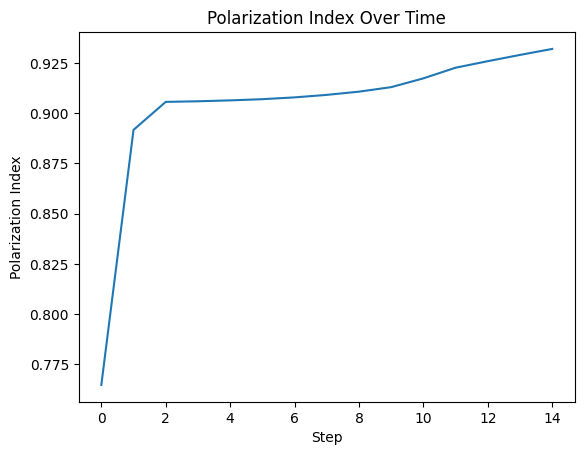

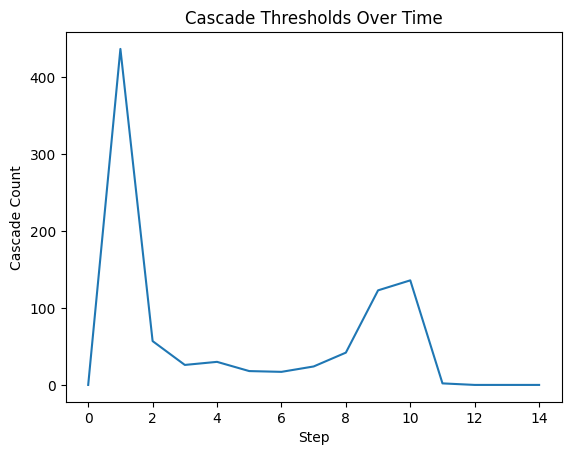

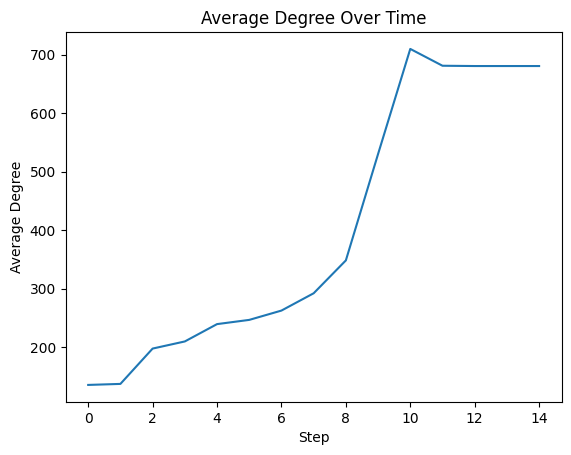

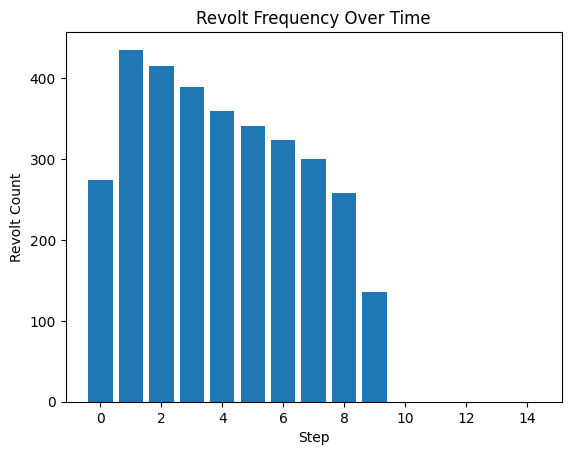

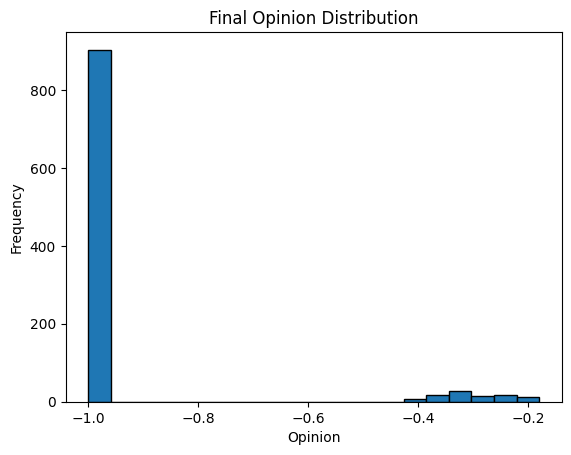

In [10]:
starter_model.visualize_metrics()